# Churn Prediction Pipeline

## Imports and Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Imports and Basic View

In [3]:
file_path = "E Commerce Dataset 1.csv"
data = pd.read_csv(file_path)

print("Data Shape:", data.shape)
print("Columns:", data.columns.tolist())
display(data.head())
display(data.describe(include='all'))
print("Missing values per column:\n", data.isnull().sum())

Data Shape: (5630, 20)
Columns: ['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630,5630.000000,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,NaN,NaN,NaN,3,NaN,NaN,7,2,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Mobile Phone,NaN,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2765,NaN,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,52815.500000,0.168384,10.189899,NaN,1.654707,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,0.374240,8.557241,NaN,0.915389,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,0.000000,0.000000,NaN,1.000000,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,NaN,1.000000,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,NaN,1.000000,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,NaN,3.000000,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000


Missing values per column:
 CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


## Initial Visualizations

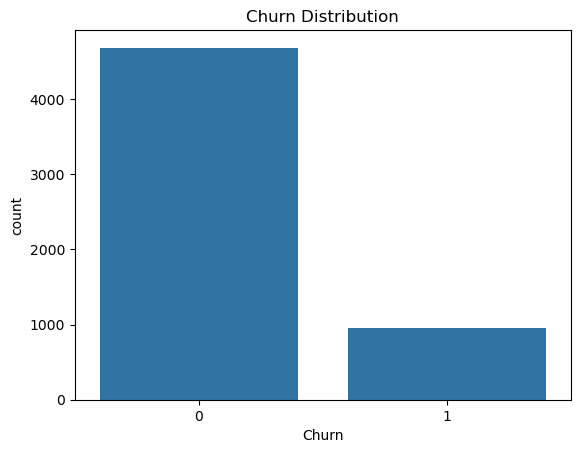

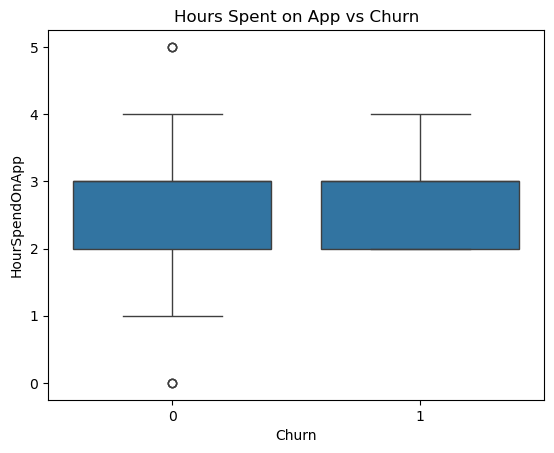

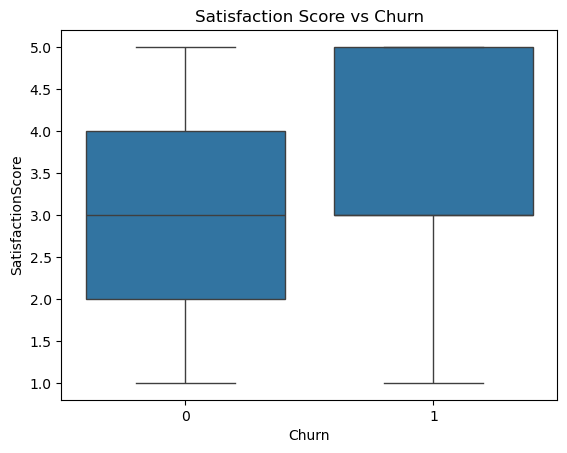

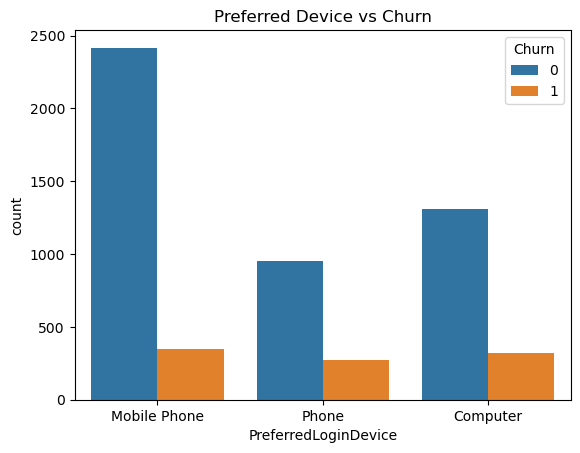

In [4]:
#Distribution of churn column
sns.countplot(x='Churn', data=data)
plt.title("Churn Distribution")
plt.show()

# Visualizing relationships between features and churn
sns.boxplot(x='Churn', y='HourSpendOnApp', data=data)
plt.title("Hours Spent on App vs Churn")
plt.show()

sns.boxplot(x='Churn', y='SatisfactionScore', data=data)
plt.title("Satisfaction Score vs Churn")
plt.show()

#categorical feature analysis
sns.countplot(x='PreferredLoginDevice', hue='Churn', data=data)
plt.title("Preferred Device vs Churn")
plt.show()

## Data Cleaning

In [10]:
data = data.dropna(subset=['CustomerID', 'Churn'])  # essential columns

categorical_features = [
    'PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 
    'Gender', 'MaritalStatus', 'PreferedOrderCat'
]
numeric_features = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'
]
for col in numeric_features:
    if col in data.columns:
        median_val = data[col].median()
        data[col].fillna(median_val, inplace=True)
        
print("Missing values after numeric imputation:\n", data[numeric_features].isnull().sum())

Missing values after numeric imputation:
 Tenure                         0
WarehouseToHome                0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
NumberOfAddress                0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64


In [11]:
#Audit summary
print("\nData Cleaning Audit Summary:")
print(f"Total Rows after Cleaning: {data.shape[0]}")
print(f"Total Unique Customers after Cleaning: {data['CustomerID'].nunique()}")
# If 'Country' column exists, print its nunique, else skip
if 'Country' in data.columns:
	print(f"Total Countries after Cleaning: {data['Country'].nunique()}")
print("Data check:", display(data.head(5)))


Data Cleaning Audit Summary:
Total Rows after Cleaning: 5630
Total Unique Customers after Cleaning: 5630


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,9.0,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,9.0,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,3.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


Data check: None


## Feature Engineering

In [17]:
# Average order value
data['AverageOrderValue'] = data['OrderAmountHikeFromlastYear'] / (data['OrderCount'].replace(0,1))

# Cashback per order
data['CashbackPerOrder'] = data['CashbackAmount'] / (data['OrderCount'].replace(0,1))

# Coupon usage per order
data['CouponPerOrder'] = data['CouponUsed'] / (data['OrderCount'].replace(0,1))

# Time spent per device
data['HourPerDevice'] = data['HourSpendOnApp'] / (data['NumberOfDeviceRegistered'].replace(0,1))

# Recency flags
data['RecentActivityFlag'] = (data['DaySinceLastOrder'] <= 30).astype(int)
data['InactiveFlag'] = (data['DaySinceLastOrder'] > 60).astype(int)

# Complaint rate
data['ComplaintRate'] = data['Complain'] / (data['OrderCount'].replace(0,1))

# Satisfaction normalized by tenure
data['SatisfactionPerTenure'] = data['SatisfactionScore'] / (data['Tenure'].replace(0,1))

# Device & Payment mode
data['Device_Payment_Interaction'] = data['PreferredLoginDevice'].astype(str) + '_' + data['PreferredPaymentMode'].astype(str)

# City tier & Average order value
data['City_AOV_Interaction'] = data['CityTier'].astype(str) + '_' + pd.cut(data['AverageOrderValue'], bins=3, labels=['Low', 'Medium', 'High']).astype(str)

# Coupon usage & Satisfaction
data['Coupon_Satisfaction_Ratio'] = data['CouponPerOrder'] / (data['SatisfactionPerTenure'].replace(0,np.nan))

# Fill any NaNs from division by zero with median
numeric_features_to_fill = ['Coupon_Satisfaction_Ratio', 'CashbackPerOrder', 'HourPerDevice', 'ComplaintRate', 'SatisfactionPerTenure', 'AverageOrderValue', 'CouponPerOrder']
for col in numeric_features_to_fill:
    data[col].fillna(data[col].median(), inplace=True)

categorical_features += ['Device_Payment_Interaction', 'City_AOV_Interaction']
numeric_features += ['AverageOrderValue', 'CashbackPerOrder', 'CouponPerOrder', 'HourPerDevice',
                    'RecentActivityFlag', 'InactiveFlag', 'ComplaintRate', 'SatisfactionPerTenure',
                    'Coupon_Satisfaction_Ratio']


In [18]:
print("Updated Data Shape:", data.shape)
print("Sample of engineered features:")
display(data[categorical_features + numeric_features].head())

Updated Data Shape: (5630, 31)
Sample of engineered features:


,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,MaritalStatus,PreferedOrderCat,Device_Payment_Interaction,City_AOV_Interaction,Tenure,WarehouseToHome,...,CashbackAmount,AverageOrderValue,CashbackPerOrder,CouponPerOrder,HourPerDevice,RecentActivityFlag,InactiveFlag,ComplaintRate,SatisfactionPerTenure,Coupon_Satisfaction_Ratio
0,Mobile Phone,3,Debit Card,Female,Single,Laptop & Accessory,Mobile Phone_Debit Card,3_Medium,4.0,6.0,...,160,11.0,160.0,1.0,1.00,1,0,1.0,0.500000,2.0
1,Phone,1,UPI,Male,Single,Mobile,Phone_UPI,1_Medium,9.0,8.0,...,121,15.0,121.0,0.0,0.75,1,0,1.0,0.333333,0.0
2,Phone,1,Debit Card,Male,Single,Mobile,Phone_Debit Card,1_Medium,9.0,30.0,...,120,14.0,120.0,0.0,0.50,1,0,1.0,0.333333,0.0
3,Phone,3,Debit Card,Male,Single,Laptop & Accessory,Phone_Debit Card,3_High,0.0,15.0,...,134,23.0,134.0,0.0,0.50,1,0,0.0,5.000000,0.0
4,Phone,1,CC,Male,Single,Mobile,Phone_CC,1_Medium,0.0,12.0,...,130,11.0,130.0,1.0,1.00,1,0,0.0,5.000000,0.2


## Data Split

In [19]:
X = data[categorical_features + numeric_features]
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

## Pipeline Setup

In [20]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## Modeling Strategy

In [21]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {'model__C': [0.1, 1, 10]},
    "RandomForest": {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None]},
    "GradientBoosting": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1]}
}

best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    grid = GridSearchCV(pipe, param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV ROC-AUC: {grid.best_score_:.4f}")


--- Training LogisticRegression ---


Best params: {'model__C': 1}
Best CV ROC-AUC: 0.8977

--- Training RandomForest ---
Best params: {'model__max_depth': None, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9715

--- Training GradientBoosting ---
Best params: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9506


## Evaluation


Model: LogisticRegression
ROC-AUC: 0.8879928799720387
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1171
           1       0.73      0.55      0.63       237

    accuracy                           0.89      1408
   macro avg       0.82      0.76      0.78      1408
weighted avg       0.88      0.89      0.88      1408



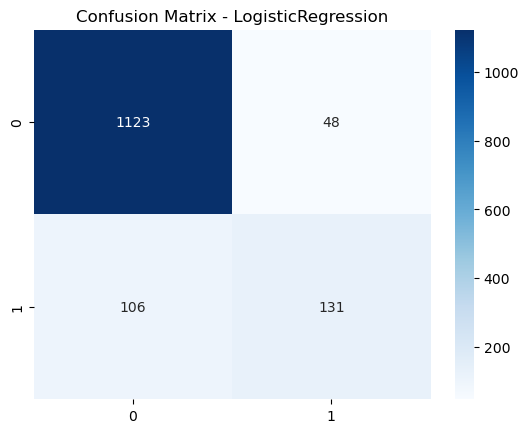


Model: RandomForest
ROC-AUC: 0.9894730963113498
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1171
           1       0.96      0.75      0.84       237

    accuracy                           0.95      1408
   macro avg       0.95      0.87      0.91      1408
weighted avg       0.95      0.95      0.95      1408



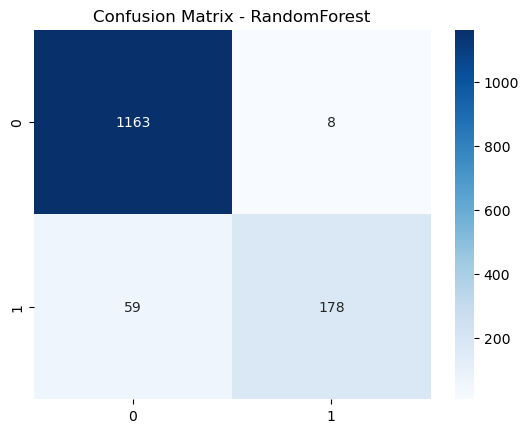


Model: GradientBoosting
ROC-AUC: 0.9578527494622145
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1171
           1       0.82      0.70      0.75       237

    accuracy                           0.92      1408
   macro avg       0.88      0.83      0.85      1408
weighted avg       0.92      0.92      0.92      1408



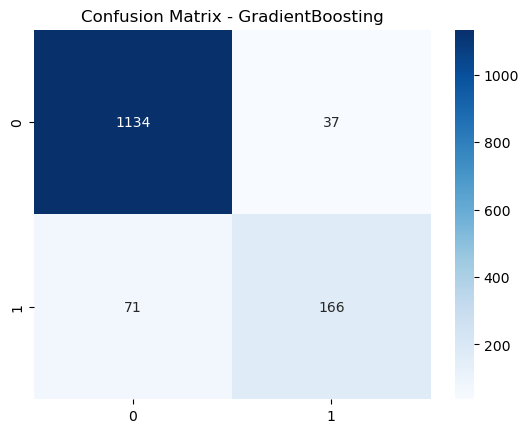

In [22]:

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print(f"\nModel: {name}")
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

## Document Insights

Best model was random forrest. With hypertuning of parameters I hope to increase the model predicting churn, it currently is showing .77 for recall and I think it can be improved!

## Hyperparameter Tuning

In [26]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2', None]
}

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=400; total time=   1

Test ROC-AUC: 0.9908729601083859
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1171
           1       0.96      0.77      0.85       237

    accuracy                           0.96      1408
   macro avg       0.96      0.88      0.91      1408
weighted avg       0.96      0.96      0.95      1408



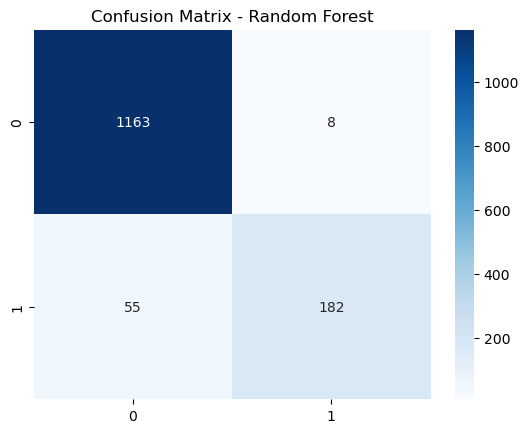

In [28]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()